<a href="https://colab.research.google.com/github/nse-yu/colab-ML/blob/main/human_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 人の顔識別

### データロード＆前処理編

> 画像セットの読み込み

In [ ]:
!cp "/content/drive/MyDrive/imgs_deep.zip" .

In [ ]:
!unzip imgs_deep.zip

> 読み込み

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2
import glob
import numpy as np
from PIL import Image

> 画像読み込み関数

In [ ]:
def imget(paths):
  """
  画像のpathリストを指定し、その画像をリストで返す。
  """

  #データセットを格納する変数
  x_train = []
  #リサイズ後のサイズ
  IMG_RATE = 0.4

  #個別のFilePathに対して処理していきます。
  for p in paths:
    pathEach = p
    print(pathEach)

    img_before = cv2.imread(pathEach)
    if img_before is None:
      continue
    print(img_before.shape)
    img_after = cv2.resize(img_before, dsize=(32,32))
    img_after = cv2.cvtColor(img_after,cv2.COLOR_BGR2RGB)
    img_after = img_after.astype("float64") / 255

    x_train.append(img_after)
  return np.array(x_train)

> 人の画像

In [ ]:
os.chdir("/content/imgs_deep") #階層をカレントからimgs_deepに移動
paths = glob.glob("*") #階層内のすべてのファイルパスを取得

x_train_true = imget(paths)

> その他の画像

In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
data = unpickle("/content/data_batch_1")

In [ ]:
val_data = unpickle("/content/data_batch_2")

In [ ]:
def preFalse(data):
  x_train_false = data[b"data"]
  print(x_train_false.shape) #10000個の画像、3072のうち最初の1/3はred,次がgreen,最後がblue

  #red
  x_train_false_r = x_train_false[:,:1024].reshape(10000,32,32)

  #green
  x_train_false_g = x_train_false[:,1024:2048].reshape(10000,32,32)

  #blue
  x_train_false_b = x_train_false[:,2048:].reshape(10000,32,32)

  #rgb化
  x_train_false = np.array([x_train_false_r,x_train_false_g,x_train_false_b]).transpose((1,2,3,0)).astype("float64") / 255
  return x_train_false

> 訓練、テストデータ取得

In [ ]:
x_train_false = preFalse(data)
x_test_false = preFalse(val_data)

(10000, 3072)
(10000, 3072)


> 比較

In [ ]:
print(x_train_true.max())
print(x_train_false.max())

1.0
1.0


> ラベルの付与

In [ ]:
#trueラベル
x_t = np.zeros(shape=(x_train_true.shape[0]))
x_t[:] = True

#falseラベル
x_f = np.zeros(shape=(x_train_false.shape[0]))
x_f[:] = False

x_train = np.concatenate([x_train_true,x_train_false])
t_train = np.concatenate([x_t,x_f])

> 訓練データの結合

In [ ]:
r_idx = np.random.permutation(len(x_train)) #indexをランダムにすることで、データとラベルの対応を保持することができる

#この２つが訓練用データとなる
x_train = x_train[r_idx]
t_train = t_train[r_idx]

> 訓練、テストデータ分割

In [ ]:
print(x_train.shape)

(23233, 32, 32, 3)


In [ ]:
#テスト用
x_test = x_train[23200:]
t_test = t_train[23200:]
#訓練用
x_train = x_train[:23200]
t_train = t_train[:23200]


### 学習編

In [ ]:
from tensorflow import keras
import numpy as np

> データ最終確認

In [ ]:
print(x_train.shape)
print(t_train.shape)

(23200, 32, 32, 3)
(23200,)


> モデルひな形作成

In [ ]:
#層
#input_ = keras.layers.Input(shape=(np.prod(x_train.shape[1:]),)) flatten版
input_ = keras.layers.Input(shape=(x_train.shape[1:]),)

cv1 = keras.layers.Conv2D(filters=3,kernel_size=3)(input_)
drop1 = keras.layers.Dropout(0.25)(cv1)

cv2 = keras.layers.Conv2D(filters=1,kernel_size=2)(drop1)
drop2 = keras.layers.Dropout(0.25)(cv2)

flatten = keras.layers.Flatten()(drop2)

output = keras.layers.Dense(units=1,activation="relu")(flatten)

#モデル
model = keras.models.Model(inputs=input_,outputs=[output])

> モデル詳細

In [ ]:
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_22 (Conv2D)          (None, 29, 29, 5)         245       
                                                                 
 conv2d_23 (Conv2D)          (None, 27, 27, 2)         92        
                                                                 
 conv2d_24 (Conv2D)          (None, 26, 26, 1)         9         
                                                                 
 flatten_19 (Flatten)        (None, 676)               0         
                                                                 
 dense_56 (Dense)            (None, 1)                 677       
                                                                 
Total params: 1,023
Trainable params: 1,023
Non-trainable 

> モデルのコンパイル

In [ ]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
    )

> 訓練

In [ ]:
#任意
"""
x_train = x_train.flatten().reshape(x_train.shape[0],-1)
print(x_train.shape)
print(t_train.shape)
"""

(23233, 3072)
(23233,)


In [ ]:
history = model.fit(x_train,t_train,epochs=20,validation_split=0.2)

Epoch 1/20
580/580 [==============================] - 11s 18ms/step - loss: 1.6924 - accuracy: 0.6426 - val_loss: 0.4768 - val_accuracy: 0.8159
Epoch 2/20
580/580 [==============================] - 10s 18ms/step - loss: 0.7192 - accuracy: 0.8067 - val_loss: 0.2641 - val_accuracy: 0.9272
Epoch 3/20
580/580 [==============================] - 10s 18ms/step - loss: 0.3107 - accuracy: 0.9093 - val_loss: 0.1863 - val_accuracy: 0.9504
Epoch 4/20
580/580 [==============================] - 11s 18ms/step - loss: 0.2618 - accuracy: 0.9241 - val_loss: 0.1977 - val_accuracy: 0.9506
Epoch 5/20
580/580 [==============================] - 10s 18ms/step - loss: 0.3281 - accuracy: 0.9180 - val_loss: 0.1875 - val_accuracy: 0.9453
Epoch 6/20
580/580 [==============================] - 10s 18ms/step - loss: 0.2088 - accuracy: 0.9392 - val_loss: 0.1384 - val_accuracy: 0.9616
Epoch 7/20
580/580 [==============================] - 10s 18ms/step - loss: 0.1766 - accuracy: 0.9515 - val_loss: 0.1260 - val_accuracy:

In [ ]:
model.save("/content/drive/MyDrive/data/face_indentify_ver1")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/data/face_indentify_ver1/assets


### 検証編

> ランダム画像の確認

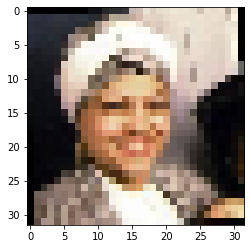

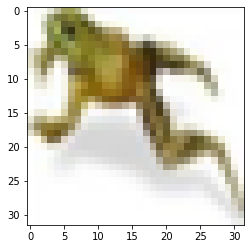

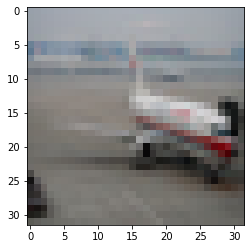

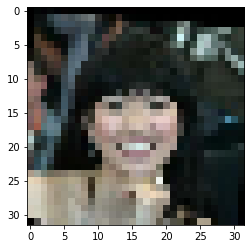

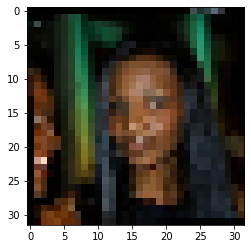

In [ ]:
for entry in x_test[:5]:
  plt.imshow(entry)
  plt.show()

In [ ]:
model.evaluate(x_test,t_test)

2/2 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 1.0000


[0.03188124671578407, 1.0]

> 予測関数（0か1にするだけ）

In [ ]:
def my_predict(data):
  ans = model.predict(data)
  ans = np.round(ans).astype(int)
  return np.where(ans >= 2,1,ans)

> テストデータで予測

In [ ]:
pred_result = my_predict(x_test[:30])
print(pred_result)
print(t_test[:30])

[[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]]
[1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1.]


> 別のデータで予測

In [ ]:
lena = imget(["/content/lena.png"])

/content/lena.png
(256, 256, 3)


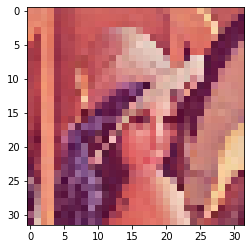

In [ ]:
plt.imshow(lena[0])
plt.show()

In [ ]:
my_predict(lena)

array([[1]])

In [ ]:
hum = imget(["/content/hum.jpg"])

/content/hum.jpg
(973, 1024, 3)


In [ ]:
my_predict(hum)

array([[0]])